#### **Library**

In [53]:
from google.colab import drive

# Mount Google-Drive Directory
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from google.colab import userdata
warnings.filterwarnings('ignore')

In [55]:
FOLDER_PATH = Path(f"{userdata.get('FOLDER_PATH')}/SentXAI-Covid19")
%cd $FOLDER_PATH

/content/gdrive/MyDrive/AI Models/MachineLearning/SentXAI-Covid19


#### **Load Dataset**

In [56]:
# Load processed dataset
FILE_NAME = "data/processed/covid19_tweets.csv"
pd.set_option("display.max_colwidth", None)
df = pd.read_csv(FILE_NAME) \
    .dropna() \
    .reset_index(drop=True) \
    .drop("tweet", axis=1)
    # [["text", "sentiment"]]
df.head()

text  \
0                                                                                         latest driver country gas price drop amid   
1  difficult time moment stockpile panic buy buy normal plenty food essential supply thinkofothers especially elderly dontbeselfish   
2                                                          buy gift certificate online shopping time local business alive book book   
3                                                                               rental price fall time decade realestate investment   
4                                                                                  rotorua shopper wear beekeeping suit supermarket   

  sentiment  
0  negative  
1  positive  
2  positive  
3   neutral  
4   neutral

#### **Train & Test Split**

In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=43):

    X_all = df[["text"]]
    y_all = df[["sentiment"]]

    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=test_size, random_state=random_state, stratify=y_all
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df)

In [ ]:
# Load split data
train_ = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_ = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [ ]:
%%bash

# FILE_FOLDER="data/splits"
FILE_TO_LOG="train.csv"
FILE_FOLDER="data/processed"
FILE_EXIST=False

find "${FILE_FOLDER}" -type f -name "*.csv" | while read -r file; do
    if [[ "${file}" != "${FILE_TO_LOG}" ]]; then
        echo "File name: $FILE_TO_LOG does not exist!"
        FILE_EXIST=True
    else
        echo "$FILE_TO_LOG already loaded to $FILE_FOLDER"
    fi
done

File name: train.csv does not exist!


In [ ]:
# Encoding Labels
enc = LabelEncoder()
y_train_ = enc.fit_transform(y_train) #.reshape(-1, 1)
y_test_  = enc.transform(y_test) #.reshape(-1, 1)

print(y_train_.shape, y_test_.shape)

(35730,) (8933,)


#### **Model Selection**

In [ ]:
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, roc_auc_score

# ML: Algorithms
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# TfIDF Embedding
def word_processor(doc: str):
    return doc

vect = TfidfVectorizer(
    ngram_range=(1,3),
    analyzer="word",
    tokenizer=word_processor,
    preprocessor=word_processor
)

In [ ]:
# ToDo: Add Other embeddings to train the models i.e Word2Vec
# ToDo: Merge extremely negative/postive and negative/positive into positive and negative sentiments.

In [ ]:
# Calculate model metrics and output as a dictionary of those metrics
def calculate_model_metrics(model: BaseEstimator, X_values: pd.DataFrame, y_true: list) -> dict:

    f1 = f1_score(y_true, model.predict(X_values), average="weighted")
    roc_auc =  roc_auc_score(y_true, pipeline.predict_proba(X_values),  average="weighted", multi_class="ovo")

    metrics = dict(f1=np.round(f1, 3), roc_auc=np.round(roc_auc, 3))
    return metrics

# print(calculate_model_metrics(pipeline, X_train, y_train_))
# print(calculate_model_metrics(pipeline, X_test, y_test_))

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

# pipeline Implementation
baseline = DecisionTreeClassifier()

ct = make_column_transformer((vect, "text"), remainder="drop")
pipeline = make_pipeline(ct, baseline)

# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

train_scores = []
val_scores = []

for idx, (train_idx, val_idx) in tqdm(enumerate(cv.split(X_train, y_train))):

    print(" Iteration Number: ", idx+1, "...")
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_[train_idx], y_train_[val_idx]

    pipeline.fit(X_train_fold, y_train_fold)

    train_score = calculate_model_metrics(pipeline, X_train_fold, y_train_fold)
    val_score = calculate_model_metrics(pipeline, X_val_fold, y_val_fold)

    train_scores.append(train_score)
    val_scores.append(val_score)

0it [00:00, ?it/s]

 Iteration Number:  1 ...


1it [02:31, 151.56s/it]

 Iteration Number:  2 ...


2it [05:35, 170.81s/it]

 Iteration Number:  3 ...


3it [08:17, 166.62s/it]

 Iteration Number:  4 ...


4it [10:55, 163.13s/it]

 Iteration Number:  5 ...


5it [13:34, 162.83s/it]


In [ ]:
# ToDo: Aggregate cross-validation metric scores
# ToDo: Interpret the results (Does the model generalize well on unseen data?)
# ToDo: Select models that perform well for hyper-tunining purpose.

In [ ]:
train_scores

[{'f1': 0.992, 'roc_auc': 1.0},
 {'f1': 0.993, 'roc_auc': 1.0},
 {'f1': 0.993, 'roc_auc': 1.0},
 {'f1': 0.992, 'roc_auc': 1.0},
 {'f1': 0.993, 'roc_auc': 1.0}]

In [ ]:
val_scores

[{'f1': 0.214, 'roc_auc': 0.501},
 {'f1': 0.215, 'roc_auc': 0.501},
 {'f1': 0.214, 'roc_auc': 0.5},
 {'f1': 0.205, 'roc_auc': 0.493},
 {'f1': 0.212, 'roc_auc': 0.499}]

In [ ]:
from sklearn.model_selection import learning_curve

# Learning Curve Validation
train_sample = 5000
training_samples = [1000 + train_sample*c for c in range(6)]

train_sizes, train_scores, valid_scores = learning_curve(pipeline,X_train, y_train_, train_sizes=training_samples, cv=cv)

In [ ]:
# import seaborn as sns
# from matplotlib import pyplot as plt

# plt.subplots(1,1, figsize=(8, 3.5), sharey=True)
# plt.style.use("ggplot")

# sns.lineplot(x=train_sizes, y=train_scores.mean(axis=1), color='b', linestyle='--', label="Train")
# sns.lineplot(x=train_sizes, y=valid_scores.mean(axis=1), color='r', linestyle='-', label="Test")

# # Plot attributes
# plt.ylabel("Scores", fontsize=11)
# plt.xlabel("Number of training samples.", fontsize=11)
# plt.title("F1 training scores", alpha=0.8, fontsize=12)

# plt.tight_layout()
# plt.show()

In [ ]:
# ToDO: Hyper-parameter Tuning with gridsearch
# ToDo: Intergrate Mlflow Experiment tracking
# ToDo: Add Interpretations

In [ ]:
# Hyperparamter Optimizer


#### **Feature Engineering**

> #### Word2Vec Embedding

In [ ]:
#Build Embedding Model
def w2v_embedding(x_input, skip_gram=0):
    x_input = [list(w) for w in x_input]
    model = Word2Vec(
        sg=skip_gram,
        vector_size=300,
        min_count=2,
        window=5,
        seed=43,
    )

    model.build_vocab(x_input)
    model.train(x_input, total_examples=model.corpus_count, epochs=200)

    return model


In [ ]:
# words corpus
corpus_data = [sentence.split() for sentence in data.clean_text.to_numpy()]

In [ ]:
%%time
# Word2Vec-CBOW
w2v_model_cbow = w2v_embedding(corpus_data, skip_gram=0)

CPU times: total: 1min 37s
Wall time: 1min 8s


In [ ]:
%%time
# Word2Vec-Skip-Gram
w2v_model_skip = w2v_embedding(corpus_data, skip_gram=1)

CPU times: total: 5min 7s
Wall time: 2min 51s


In [ ]:
%%time
# change working directory
file_path = os.path.join(working_dir, r'keyed-vectors')

try:
    os.makedirs(file_path,)
except FileExistsError:
    print('File already exists!')

os.chdir(file_path)
# save keyedvectors
w2v_model_cbow.wv.save('cbow.wordvectors')
w2v_model_skip.wv.save('skgram.wordvectors')

# change back to main working directory
os.chdir(working_dir)

File already exists!
CPU times: total: 15.6 ms
Wall time: 72.7 ms


In [ ]:
# Embedding-Transformer
class Word2VecTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, embedding_vector):
        self.embedding_vector = embedding_vector

    def __word_embedding_vector(self, sentence):
        average = []
        for word in sentence:
            if word in  self.embedding_vector.index_to_key:
                average.append(self.embedding_vector[word])

        if not average:
            return np.zeros(self.embedding_vector.vector_size)
        else:
            return np.array(average).mean(axis=0)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        xs = [self.__word_embedding_vector(sentence) for sentence in X]
        return xs


In [ ]:
# Word2Vector Embedding Pipeline
class W2VModel:

    def __init__(self, model, x_train, y_train):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train

    def train_model(self, title, embedding_vector):
        pipeline = Pipeline([
            ('preprocessor', TextTransformer()),
            (f'{title}-embedding', Word2VecTransformer(embedding_vector)),
            ('model', self.model)
        ])

        pipeline = pipeline.fit(self.x_train, self.y_train)
        return pipeline

>#### TF-IDF Approach

In [ ]:
class TFIDFCustomTransformer(BaseEstimator, TransformerMixin):

     def __dummy(self, doc):
          return doc

     def fit(self, X, y=None):
          return self

     def transform(self, X):
          vectorizer = TfidfVectorizer(
                analyzer='word',
                tokenizer=self.__dummy,
                preprocessor=self.__dummy,
                ngram_range=(1,3))
          return vectorizer.fit_transform(X)

In [ ]:
# TFIDF Model Pipeline
class TFModel:

    def __init__(self, model, x_train, y_train):
        # Initialize attributes
        self.model = model
        self.x_train = x_train
        self.y_train = y_train

    def dummy(self, doc):
        return doc

    def train_model(self):

        pipeline = Pipeline([
            ('preprocessor', TextTransformer()),
            (f'tf-idf',TfidfVectorizer(
                analyzer='word',
                tokenizer=self.dummy,
                preprocessor=self.dummy,
                ngram_range=(1,3))),
            ('model', self.model)
        ])

        pipeline = pipeline.fit(self.x_train, self.y_train)
        return pipeline

#### **Build Models**

In [ ]:
import copy
import joblib
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

> #### Evaluation

In [ ]:
class ModelEval:
    '''
        * The class takes in a sklearn-pipeline, x and y-validations as inputs
        *
    '''
    def __init__(self, pipeline,x_val, y_val):

        # input attributes
        self.x_val = x_val
        self.y_val = y_val
        self.pipeline =  pipeline

        # perfoms predictions
        self.predicted =  self.pipeline.predict_proba(self.x_val)

        # round floating points into 3 decimals
        self.format_matric = lambda x: float('{:,.3f}'.format(x))

    # return predicted values
    def get_predictions(self):
        return self.predicted

    # return metrics
    def get_metrics(self):

        # accuracy score
        acc = accuracy_score(self.y_val , self.predicted.argmax(axis=-1))

        # f1-score
        f1 = f1_score(self.y_val , self.predicted.argmax(axis=-1), average='weighted')

        # log metrics
        metric_values = dict(accuracy= self.format_matric(acc), f1= self.format_matric(f1))

        return metric_values

    # show indivial performance per class
    def show_classification_report(self):
        print(classification_report(self.y_val , self.predicted.argmax(axis=-1), target_names=label_to_index.keys()))

    # output confusion matrix
    def confusion_matrix_plot(self, cmap='inferno'):
        # finding confusion title
        pipeline_keys = list(self.pipeline.named_steps.keys())
        model_name = self.pipeline.named_steps['model'].__class__.__name__.lower()
        model_alias = pipeline_keys[1] + "-" + model_name
        # # #


        fig, ax = plt.subplots(1,1, figsize=(10,6))
        labels = list(label_to_index.keys())
        ticks =list(label_to_index.values())

        confusion_mat = confusion_matrix(y_val, self.predicted.argmax(axis=-1))
        sns.heatmap(confusion_mat, annot=True, fmt='.1f', cmap=cmap,cbar=False, ax=ax)

        ax.set_xticklabels(labels)
        ax.set_xlabel('True Labels',  fontsize='11', fontweight='bold')
        ax.set_yticks(ticks, labels, rotation=0)
        ax.set_yticklabels(list(label_to_index.keys()))
        ax.set_title(f'Confusion matrix for {model_alias}', fontsize='12')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels', fontsize='11', fontweight='bold')

        plt.tight_layout()
        plt.show()

>#### Serializer &  Deserializer

In [ ]:
class ModelBinarizer:
    def __init__(self, path):
        self.path = path

    # serialize
    def save_model(self, model, file_name):
        with open(os.path.join(self.path, file_name), 'wb') as file:
            try:
                joblib.dump(model, file)
                print(f'Pipeline has been saved successful as {file_name}')
            except Exception as exp:
                print(f'Saving pipeline failed with the following error: {exp}')
            finally:
                print('Process completed!!')

    # deserialize
    def load_model(self, file_name):
        with open(os.path.join(self.path, file_name), 'rb') as file:
            try:
                return joblib.load(file)
            except Exception as exp:
                print(f'File loading failed with the follwoing exception: {exp}')
            finally:
                print('Process completed!!')

> #### Additional information

In [ ]:
%%time
# change working directory
os.chdir(file_path)

# Load keyed-vectors
cbow_keyedvectors = KeyedVectors.load('cbow.wordvectors')
sg_keyedvectors  = KeyedVectors.load('skgram.wordvectors')

# change back to main working directory
os.chdir(working_dir)

CPU times: total: 0 ns
Wall time: 1.02 s


In [ ]:
# initialize serialization and deserialization
model_path = os.path.join(working_dir, r'trained-models')

try:
    os.makedirs(model_path)
except FileExistsError:
    print('File already exists!')

save_load_model = ModelBinarizer(model_path)

>##### Logistic Model

In [ ]:
# initialize model
lr_params = dict(
    penalty='l2', C=5,
    max_iter=500,multi_class='multinomial',
    solver='lbfgs', random_state=43
)

lr = LogisticRegression(**lr_params)

In [ ]:
%%time
# lr-skip-gram
w2v_model = W2VModel(lr, x_train=x_train, y_train=y_train) # initial embedding model
trained_model = w2v_model.train_model('skip', sg_keyedvectors) # train model
pipeline = copy.deepcopy(trained_model) # deep copy pipeline to prevent a model from being overridden
save_load_model.save_model(pipeline, r'lr_sg_pipe.joblib') # save model to local directory

# release memory
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as lr_sg_pipe.joblib
Process completed!!
CPU times: total: 16.3 s
Wall time: 46.3 s


Process completed!!
{'accuracy': 0.897, 'f1': 0.897}
              precision    recall  f1-score   support

         neg       0.88      0.89      0.89       872
         pos       0.91      0.90      0.91      1061

    accuracy                           0.90      1933
   macro avg       0.90      0.90      0.90      1933
weighted avg       0.90      0.90      0.90      1933



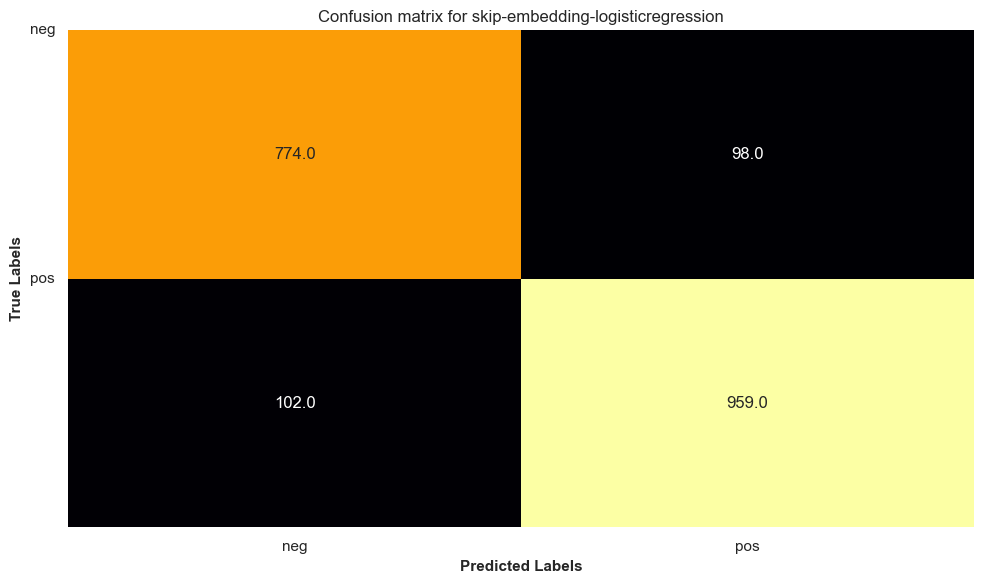

CPU times: total: 4.06 s
Wall time: 56.2 s


In [ ]:
%%time
## evaluation
lr_sg = save_load_model.load_model('lr_sg_pipe.joblib') # load model pipeline

lr_sg_eval = ModelEval(lr_sg, x_val, y_val) # load evaluation pipeline
lr_sg_metrics = lr_sg_eval.get_metrics() # retrieve model overall metrics

print(lr_sg_metrics)

# classification report
lr_sg_eval.show_classification_report()

# confusion metrix
lr_sg_eval.confusion_matrix_plot()


In [ ]:
%%time
# lr-cbow-gram
w2v_model = W2VModel(lr, x_train=x_train, y_train=y_train)
trained_model = w2v_model.train_model('cbow', cbow_keyedvectors)
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'lr_cb_pipe.joblib')
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as lr_cb_pipe.joblib
Process completed!!
CPU times: total: 18.2 s
Wall time: 35.8 s


Process completed!!
{'accuracy': 0.91, 'f1': 0.91}
              precision    recall  f1-score   support

         neg       0.90      0.90      0.90       872
         pos       0.92      0.92      0.92      1061

    accuracy                           0.91      1933
   macro avg       0.91      0.91      0.91      1933
weighted avg       0.91      0.91      0.91      1933



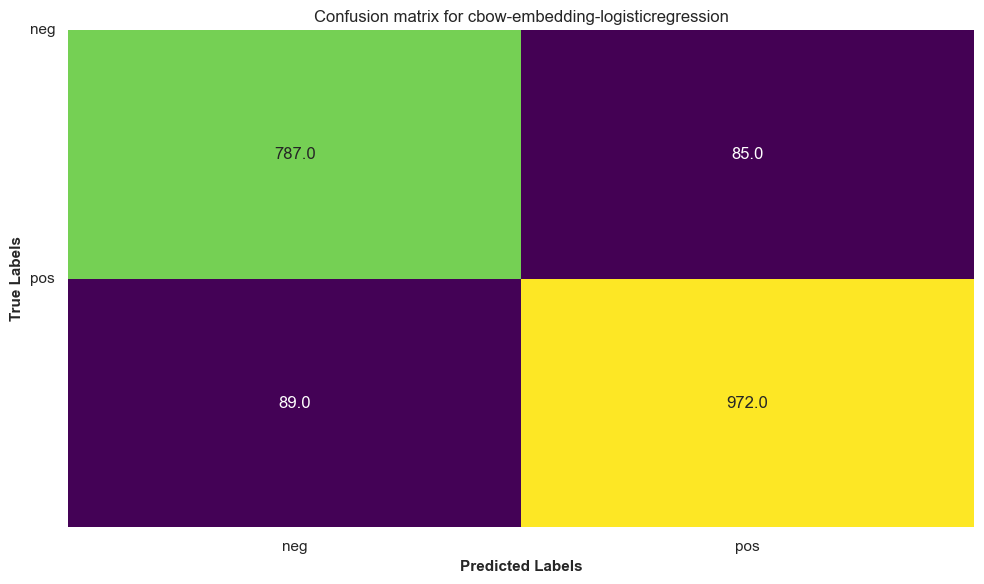

CPU times: total: 4.28 s
Wall time: 10.9 s


In [ ]:
%%time
## evaluation
lr_cb = save_load_model.load_model('lr_cb_pipe.joblib')

lr_cb_eval = ModelEval(lr_cb, x_val, y_val)
lr_cb_metrics = lr_cb_eval.get_metrics()


print(lr_cb_metrics)

# classification report
lr_cb_eval.show_classification_report()

# confusion metrix
lr_cb_eval.confusion_matrix_plot(cmap='viridis')

In [ ]:
%%time
# lr-tf-idf
tfidf_model = TFModel(lr, x_train=x_train, y_train=y_train)
trained_model = tfidf_model.train_model()
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'lr_tf_pipe.joblib')

del trained_model
del tfidf_model
del pipeline

Pipeline has been saved successful as lr_tf_pipe.joblib
Process completed!!
CPU times: total: 20.9 s
Wall time: 1min 39s


Process completed!!
{'accuracy': 0.935, 'f1': 0.935}
              precision    recall  f1-score   support

         neg       0.94      0.92      0.93       872
         pos       0.93      0.95      0.94      1061

    accuracy                           0.93      1933
   macro avg       0.94      0.93      0.93      1933
weighted avg       0.93      0.93      0.93      1933



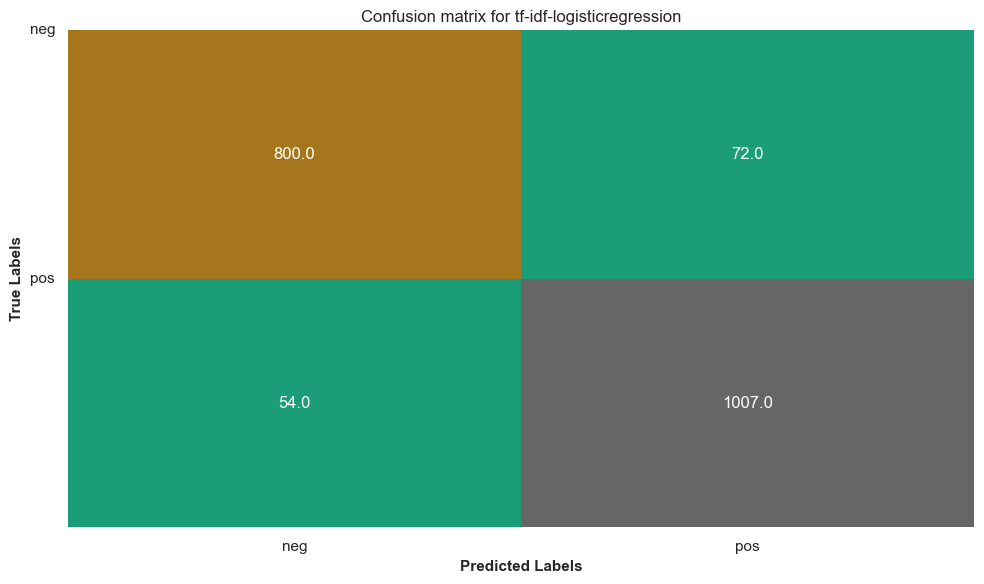

CPU times: total: 4.39 s
Wall time: 10.9 s


In [ ]:
%%time
## evaluation
lr_tf = save_load_model.load_model(r'lr_tf_pipe.joblib')

lr_tf_eval = ModelEval(lr_tf, x_val, y_val)
lr_tf_metrics = lr_tf_eval.get_metrics()

print(lr_tf_metrics)

# classification report
lr_tf_eval.show_classification_report()

# confusion metrix
lr_tf_eval.confusion_matrix_plot(cmap='Dark2')

>#### Support-Vector Model

In [ ]:
# define model
svm_params = dict(C=5, kernel='rbf', probability=True)
svm = SVC(**svm_params)

In [ ]:
%%time
# svm-skip-gram
w2v_model = W2VModel(svm, x_train=x_train, y_train=y_train)
trained_model = w2v_model.train_model('skip', sg_keyedvectors)
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'svm_sg_pipe.joblib')
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as svm_sg_pipe.joblib
Process completed!!
CPU times: total: 40.3 s
Wall time: 1min 29s


Process completed!!
{'accuracy': 0.915, 'f1': 0.915}
              precision    recall  f1-score   support

         neg       0.90      0.91      0.91       872
         pos       0.92      0.92      0.92      1061

    accuracy                           0.92      1933
   macro avg       0.91      0.91      0.91      1933
weighted avg       0.92      0.92      0.92      1933



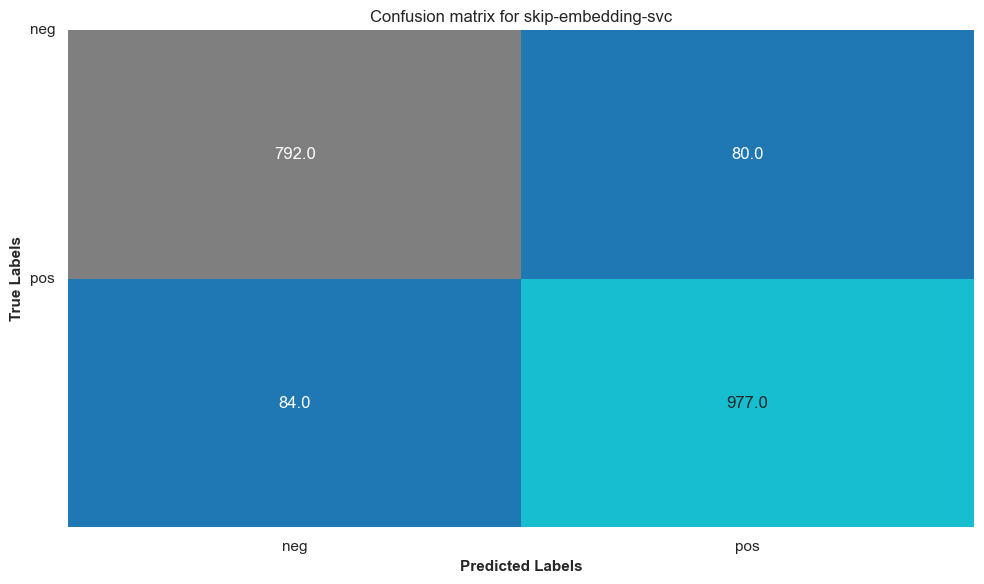

CPU times: total: 5.06 s
Wall time: 11.1 s


In [ ]:
%%time
## evaluation
svm_sg = save_load_model.load_model(r'svm_sg_pipe.joblib')

svm_sg_eval = ModelEval(svm_sg, x_val, y_val)
svm_sg_metrics = svm_sg_eval.get_metrics()

print(svm_sg_metrics)

# classification report
svm_sg_eval.show_classification_report()

# confusion metrix
svm_sg_eval.confusion_matrix_plot(cmap='tab10')

In [ ]:
%%time
# svm-cbow-gram
w2v_model = W2VModel(svm, x_train=x_train, y_train=y_train)
trained_model = w2v_model.train_model('cbow', cbow_keyedvectors)
pipeline = copy.deepcopy(trained_model)
save_load_model.save_model(pipeline, r'svm_cb_pipe.joblib')
del w2v_model
del pipeline
del trained_model

Pipeline has been saved successful as svm_cb_pipe.joblib
Process completed!!
CPU times: total: 35.6 s
Wall time: 1min 23s


Process completed!!
{'accuracy': 0.921, 'f1': 0.921}
              precision    recall  f1-score   support

         neg       0.91      0.91      0.91       872
         pos       0.93      0.93      0.93      1061

    accuracy                           0.92      1933
   macro avg       0.92      0.92      0.92      1933
weighted avg       0.92      0.92      0.92      1933



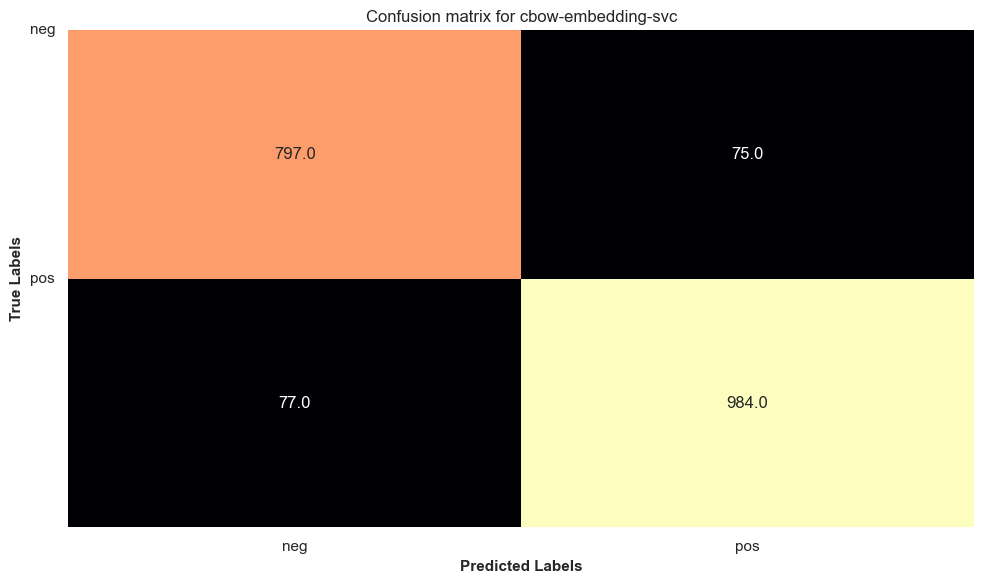

CPU times: total: 6 s
Wall time: 11.1 s


In [ ]:
%%time
## evaluation
svm_cb = save_load_model.load_model(r'svm_cb_pipe.joblib') # load pipeline from local directory

svm_cb_eval = ModelEval(svm_cb, x_val, y_val) # load model evaluation pipeline
svm_cb_metrics = svm_cb_eval.get_metrics() # retrive overall model metrics

print(svm_cb_metrics)

# classification report
svm_cb_eval.show_classification_report()

# confusion metrix
svm_cb_eval.confusion_matrix_plot(cmap='magma')

In [ ]:
%%time
# svm-tf-idf
tfidf_model = TFModel(svm, x_train=x_train, y_train=y_train) # load TF-IDF Pipeline
trained_model = tfidf_model.train_model() # train TF-IDF Pipeline
pipeline = copy.deepcopy(trained_model) # deepcopy trained model - prevent a model from overridden
save_load_model.save_model(pipeline, r'svm_tf_pipe.joblib') # save a model to local directory

del tfidf_model # realse memory
del pipeline
del trained_model

Pipeline has been saved successful as svm_tf_pipe.joblib
Process completed!!
CPU times: total: 1min 28s
Wall time: 2min 58s


Process completed!!
{'accuracy': 0.929, 'f1': 0.929}
              precision    recall  f1-score   support

         neg       0.92      0.92      0.92       872
         pos       0.94      0.93      0.94      1061

    accuracy                           0.93      1933
   macro avg       0.93      0.93      0.93      1933
weighted avg       0.93      0.93      0.93      1933



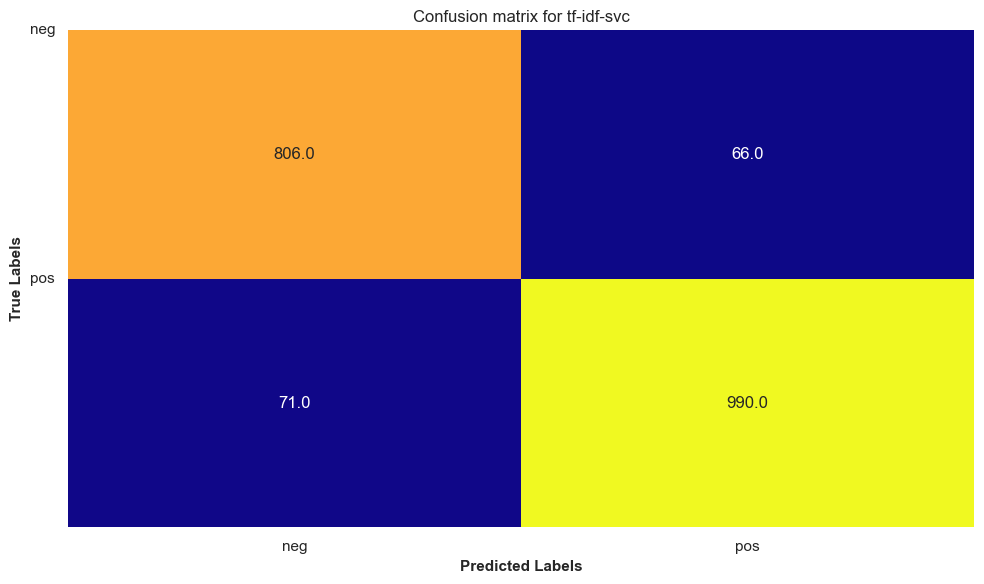

CPU times: total: 6.56 s
Wall time: 16.8 s


In [ ]:
%%time
## evaluation
svm_tf = save_load_model.load_model(r'svm_tf_pipe.joblib')

svm_tf_eval = ModelEval(svm_tf, x_val, y_val)
svm_tf_metrics = svm_tf_eval.get_metrics()

print(svm_tf_metrics)

# classification report
svm_tf_eval.show_classification_report()

# confusion metrix
svm_tf_eval.confusion_matrix_plot(cmap='plasma')

> ##### Compare Models

In [ ]:
score_df = pd.DataFrame(columns=['model', 'accuracy', 'f1-score'])

score_df.loc[len(score_df.index)] = ['lr-sgram', *list(lr_sg_metrics.values())]
score_df.loc[len(score_df.index)] = ['lr-cbow', *list(lr_cb_metrics.values())]
score_df.loc[len(score_df.index)] = ['lr-tfidf', *list(lr_tf_metrics.values())]
score_df.loc[len(score_df.index)] = ['svm-sgram' , *list(svm_sg_metrics.values())]
score_df.loc[len(score_df.index)] = ['svm-cbow', *list(svm_cb_metrics.values())]
score_df.loc[len(score_df.index)] = ['svm-tfidf', *list(svm_tf_metrics.values())]
score_df.sort_values(['accuracy', 'f1-score'], ascending=False, axis=0, inplace=True)
score_df.reset_index(drop=True, inplace=True)

In [ ]:
from IPython.display import HTML, display

display(score_df)

model  accuracy  f1-score
0   lr-tfidf     0.935     0.935
1  svm-tfidf     0.929     0.929
2   svm-cbow     0.921     0.921
3  svm-sgram     0.915     0.915
4    lr-cbow     0.910     0.910
5   lr-sgram     0.897     0.897

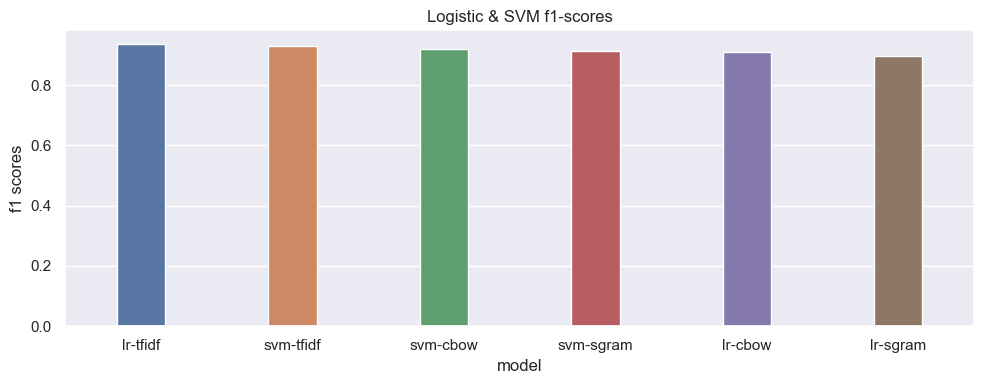

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.set_theme(font_scale=1, context='notebook')

temp_df = score_df.sort_values(['f1-score'], ascending=False, axis=0)
sns.barplot(temp_df, x='model', y='f1-score', hue='model', gap=0.6, ax=ax)
# ax.set_xticks(labels=)
# ax.legend(title='accuracy-scores', loc=4)
ax.set_ylabel('f1 scores')
ax.set_xlabel('model')
ax.set_title('Logistic & SVM f1-scores')
plt.tight_layout()
plt.show()

del temp_df

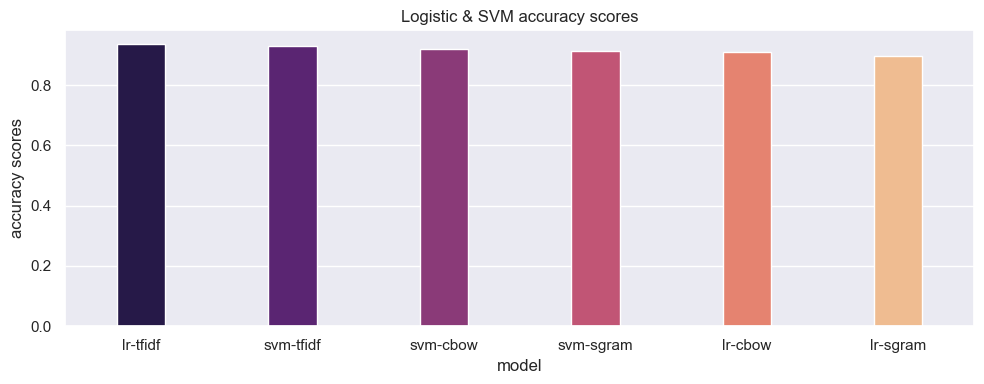

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.set_theme(font_scale=1, context='notebook')
temp_df = score_df.sort_values(['accuracy'], ascending=False, axis=0)
sns.barplot(temp_df, x='model', y='accuracy', hue='model', palette='magma', gap=0.6, ax=ax)
# ax.set_xticks(labels=)
# ax.legend(title='accuracy-scores', loc=4)
ax.set_ylabel('accuracy scores')
ax.set_xlabel('model')
ax.set_title('Logistic & SVM accuracy scores')
plt.tight_layout()
plt.show()
del temp_df

##### Model Results
* All models demonstrated impressive accuracy and F1-scores.
* Logistic Regression with TF-IDF attained the highest overall scores.
* Selecting the best model solely based on traditional metrics may introduce bias.
* In the next step, we assess how well a model generalizes its predictions by examining feature importances.
* The optimal model is selected based on the clarity and interpretability of its predictions from a human perspective.

#### **LIME - Explainable AI (XAI)**

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.utils import shuffle


In [ ]:
# initialize model explainer
def show_explaination(pipeline, input_text: str):

    predict_val = pipeline.predict_proba([input_text])
    map_val = predict_val.argmax(axis=-1)[0]


    pipeline_keys = list(pipeline.named_steps.keys())
    model_name = pipeline.named_steps['model'].__class__.__name__.lower()
    model_alias = pipeline_keys[1] + "-" + model_name

    print(f'Model: {model_alias}')
    print('The predicted Output: ', index_to_label.get(map_val))

    explainer = LimeTextExplainer(class_names=['negative', 'positive'])
    exp = explainer.explain_instance(input_text, pipeline.predict_proba,num_features=6)
    exp.show_in_notebook(text=True)

In [ ]:
# Randomly select sample input from test data
rows = len(x_test)
# index = np.random.randint(0, rows)
index = 2369
x_input  = x_test[index]
true_label = y_test[index]

print(f'Input Data: {x_input}')
print(f'Actual Output:', index_to_label[true_label])

#  @HeriOnlineS is with you in the fight against COVID 19 infection,

# We believe in social distancing  to avoid contact.

# Heri ensures you don't have to worry about your shopping do it from your safest space and we shall deliver

# https://t.co/Dm

Input Data: @HeriOnlineS is with you in the fight against COVID 19 infection,

We believe in social distancing  to avoid contact.

Heri ensures you don't have to worry about your shopping do it from your safest space and we shall deliver 

https://t.co/Dm
Actual Output: neg


> ##### SVM Skip-Gram Model

In [ ]:
show_explaination(svm_sg, x_input)

Model: skip-embedding-svc
The predicted Output:  neg


**Support Vector Machine**
- skipgram word2vec: correcly predict tweet as negative, but attributed words such as Heri (name of a person) and https (web-link) towards negative sentiment which may be misleading
-


> ##### SVM (CBOW) Model

In [ ]:
show_explaination(svm_cb, x_input)

Model: cbow-embedding-svc
The predicted Output:  neg


> ##### SVM(TF-IDF) Model

In [ ]:
show_explaination(svm_tf, x_input)

Model: tf-idf-svc
The predicted Output:  neg


> ##### Logistic Skip-Gram Model

In [ ]:
show_explaination(lr_sg, x_input)

Model: skip-embedding-logisticregression
The predicted Output:  pos


> ##### Logistic (BOW) model

In [ ]:
show_explaination(lr_cb, x_input)

Model: cbow-embedding-logisticregression
The predicted Output:  neg


> ##### logistic tf-idf model

In [ ]:
show_explaination(lr_tf, x_input)

Model: tf-idf-logisticregression
The predicted Output:  neg


#### **Results & Discussion**

Support Vector Machine:
- *Skip-gram Word2Vec:* Correctly predicted the tweet as negative but incorrectly attributed neutral words like "Heri" (a name) and "https" (a web link) to negative sentiment.
- *CBOW Word2Vec:* Correctly predicted the tweet as negative but misattributed neutral words like "believe" and "social" to negative sentiments.
- *TF-IDF:* Correctly predicted the tweet as negative and correctly attributed the word "Heri" to negative sentiment.
- The misattribution of positive or neutral words to negative sentiments indicates potential issues with the model's accuracy.

Logistic Regression:
- *Skip-gram Word2Vec:* Incorrectly predicted the tweet as having a positive sentiment.
- *CBOW Word2Vec:* Correctly predicted the tweet as negative but misattributed neutral words like "believe" and "social" to negative sentiments.
- *TF-IDF:* Correctly predicted the tweet as negative and accurately attributed both negative and positive sentiments to the appropriate words.

Overall Discussion:
- As discussed, logistic regression using TF-IDF outperforms the other models, showing better performance in predicting sentiments and attributing words correctly.
- The use of LIME (Local Interpretable Model-agnostic Explanations) provides insights into how the model makes its decisions and the words associated with its predictions.
- This enhances the trust and transparency of the model’s decision-making process while maintaining interpretability.

*Note:* Sample input text is index 2369 of the testing set